REPURPOSING EXISITING DRUGS FOR THE TREATMENT OF COVID-19

INSTALLING LIBRARIES AND DEPENDENCIES

In [1]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 4.7 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install TextBlob

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import os
import json
from operator import itemgetter
import nltk
import csv
csv.field_size_limit(2147483647)
#nltk.download('punkt')
import requests
import xml.etree.ElementTree as ET
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from textblob import TextBlob
import codecs
import re
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.utils import to_categorical
from keras import backend as K
from numpy import array
from numpy import asarray
from numpy import zeros
from wordcloud import WordCloud

Using TensorFlow backend.


In [6]:
COVID19_FILES_DIR = '../input/CORD-19-research-challenge/'
COVID19_FILES_2020_DIR = '../output/Covid-19 May 16 2020 Filtered/'
METADATA_FILENAME = COVID19_FILES_DIR + 'metadata.csv'
FORMATTED_FILES_DIR = '../output/Covid-19 May 16 Formatted/'
RESULTS_FILE_NAME = 'Covid-19 Filtered May 16.csv'
DRUGS_FILE_NAME = 'RxNorm Drugs API.csv'
LABELED_SENTIMENT_FILE_NAME = '../input/drugsComTrain_raw.csv'
GLOVE_FILE_NAME = '../input/glove6b100dtxt/glove.6B.100d.txt'

### Read and process Metadatada file

In [7]:
%%html
<style>
table {float:left; font-size: 14px !important;}
</style>

In [8]:
df = pd.read_csv(METADATA_FILENAME, low_memory=False, parse_dates=['publish_time'])
df.shape

(134206, 19)

In [9]:
df['publish_time'].describe()

count                  134194
unique                   7036
top       2020-01-01 00:00:00
freq                    14163
first     1870-01-01 00:00:00
last      2021-12-31 00:00:00
Name: publish_time, dtype: object

In [11]:
df.isnull().groupby(['pdf_json_files', 'pmc_json_files']).size()


pdf_json_files  pmc_json_files
False           False             40876
                True              16086
True            False              2877
                True              74367
dtype: int64

In [12]:
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636.0,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967.0,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972.0,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871.0,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888.0,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


### Keep articles for 2020 year only and having file links - pdf_json_files or pmc_json_files

In [13]:
df_2020 = df[(df['publish_time'] >= '2020-01-01') & (df['publish_time'] < pd.to_datetime('now'))]
df_2020.shape

(40542, 19)

In [14]:
# Remove records without file links
df_2020_wfiles = df_2020.dropna(subset=['pdf_json_files', 'pmc_json_files'], how='all')
df_2020_wfiles.shape

(16258, 19)

In [15]:
df_2020_wfiles.describe(include='all')

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
count,16258,15638,16258,16258,15045,10203,9.162000e+03,16258,11845,16258,16136,11712,0.0,4688,1241,15638,8546,16258,1.430300e+04
unique,16126,15587,27,15974,14913,10203,NaN,13,11769,146,15557,2532,NaN,4688,1241,15587,8546,16255,NaN
top,ptvaopgj,43e9fddd5958ee6a00e553db81c7c3594fba8b21,MedRxiv,Estimation of COVID-19 burden in Egypt,10.1016/j.lrr.2020.100201,PMC7141481,NaN,no-cc,[Figure: see text],2020-04-17 00:00:00,"Joob, Beuy; Wiwanitkit, Viroj",bioRxiv,NaN,#186517,2005.08400,document_parses/pdf_json/b28a28cd3f9f3c50b09af...,document_parses/pmc_json/PMC7018922.xml.json,https://doi.org/10.1101/2020.01.25.919787,NaN
freq,2,2,2798,4,2,1,NaN,5496,10,479,15,840,NaN,1,1,2,1,2,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,3.227897e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.161007e+08
std,NaN,NaN,NaN,NaN,NaN,NaN,1.453660e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.841597e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,2.886383e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.058582e+06
25%,NaN,NaN,NaN,NaN,NaN,NaN,3.222951e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.154054e+08


### Select files for analysis  - PMC files first then PDF files

Select PMC JSON files first as more clearly parsed

In [16]:
pmc_files = df_2020_wfiles[df_2020_wfiles['pmc_json_files'].notnull()]['pmc_json_files'].to_list()
len(pmc_files)

8546

Select PDF JSON files

In [6]:
pdf_files_df =  df_2020_wfiles[df_2020_wfiles['pmc_json_files'].isnull()]
pdf_files_df = pdf_files_df.dropna(subset=['pdf_json_files'])
pdf_files = pdf_files_df['pdf_json_files'].to_list()

*pdf_json_files* column may contain several file names joined by ; - split such strings <br/>
Split PDF JSON file names

In [7]:
files_for_analysis = pmc_files + pdf_files
files_for_analysis_splitted = [y for x in files_for_analysis for y in x.split(';')]

files_for_analysis = ['{0}{1}'.format(COVID19_FILES_DIR, element.strip()) for element in files_for_analysis_splitted]


Define publication date

In [20]:
df_metadata_date = df_2020_wfiles[['sha', 'pmcid', 'publish_time']]
df_metadata_date.head()

,sha,pmcid,publish_time
5158,44449ad1cca160ce491d7624f8ae1028f3570c45,PMC6939335,2020-01-02
5159,def41c08c3cb1b3752bcff34d3aed7f8486e1c86,PMC6940405,2020-01-02
5160,f5ae3f66face323615df39d838e056ab5fcc98df,PMC6941262,2020-01-02
5161,5be75ae4e7f8c892abd8dc396b9dbd035772c84a,PMC6941296,2020-01-02
5162,1cee4a0d0e823379ec34a462a04561bf4cd736a2,PMC6941340,2020-01-03


Define publication date for each PMC and PDF files

In [21]:
sha_list = dict(zip(df_metadata_date['sha'], df_metadata_date['publish_time']))
sha_list_s ={} 
for key, value in sha_list.items():
        try:    
          strs = key.split(';')
          if len(strs) > 1:
           for i in strs:
               sha_list_s[i.strip()] = value
          else:
           sha_list_s[key] = value
        except:
            continue
    
pmcid_list = dict(zip(df_metadata_date['pmcid'], df_metadata_date['publish_time']))

In [22]:
def get_publish_date(paper_id):
    if paper_id in sha_list_s:
        return sha_list_s.get(paper_id)
    if paper_id in pmcid_list:
        return pmcid_list.get(paper_id)

### Create Cleaned CSV file with  Document ID, Authors, Publication date, Abstract Text and Full Text

In [23]:
# Normalize Authors 
def format_authors(json_data):
    result =""
    for author in json_data:
        if len(author['suffix']) == 0:
            if len(result) > 0:
                result = result + "; " + author['first'] + ' ' + author['last']
            else:
                result = author['first'] + ' ' + author['last']
        else:
             if len(result) > 0:
                result = result + "; " + author['first'] + ' ' + author['suffix'] + ' ' + author['last']
             else:
                result = author['first'] + ' ' + author['suffix'] + ' ' + author['last']
    return result

Combine Full text body and make CSV file

In [24]:
csv_modified = []
sections = []
for filename in files_for_analysis:
        row = {"paper_id": None, "publish_date": None, "title": None, 'authors': None, "abstract": None, "text": None}
        with open(filename) as json_file:
            json_data = json.load(json_file)
            row['paper_id'] = json_data['paper_id']
            row['publish_date'] = get_publish_date(json_data['paper_id'])
            row['title'] = json_data['metadata']['title']     
            row['authors'] = format_authors(json_data['metadata']['authors'])
            # abstracts
            try:
                abstracts = [a['text'] for a in json_data['abstract']]
            except KeyError:
                abstracts = None
            if abstracts:
                abstract = "\n".join(abstracts)
                row['abstract'] = abstract
            else:
                row['abstract'] = ''
            
            # main text with sections
            texts = [(body['section'], body['text']) for body in json_data['body_text']]           
            texts_summary = {body['section']: "" for body in json_data['body_text']}
            for section, text in texts:
                texts_summary[section] += text
                sections.append(section)
            body = ""
            for section, text in texts_summary.items():
                body += section
                body += "\n"
                body += text
                body += "\n\n"
            row['text'] = body
        csv_modified.append(row)            

Clean duplicates by Publish date, Authors, Title and Abstract text

In [25]:
df_results = pd.json_normalize(csv_modified)
df_2020_clean_results = df_results.drop_duplicates(['publish_date','authors', 'title', 'abstract'])
df_2020_clean_results.describe(include='all')

,paper_id,publish_date,title,authors,abstract,text
count,16139,16139,16139,16139,16139,16139
unique,16139,146,15319,15195,5658,15944
top,46126fcffd5e985520f26e55b599ba874fb64b27,2020-04-17 00:00:00,,,,Declaration of Competing Interest\nThe authors...
freq,1,477,514,351,10417,30
first,NaN,2020-01-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,2020-05-26 00:00:00,NaN,NaN,NaN,NaN


Clean duplicates by Full text

In [26]:
df_2020_results = df_2020_clean_results.drop_duplicates(['text'])
df_2020_results.describe(include='all')

,paper_id,publish_date,title,authors,abstract,text
count,15944,15944,15944,15944,15944,15944
unique,15944,146,15131,15023,5658,15944
top,46126fcffd5e985520f26e55b599ba874fb64b27,2020-04-17 00:00:00,,,,\nServicio de Dermatología. Hospital Universit...
freq,1,474,513,350,10225,1
first,NaN,2020-01-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,2020-05-26 00:00:00,NaN,NaN,NaN,NaN


In [28]:
df2020_doc = df_2020_results['publish_date'].groupby([df_2020_results['publish_date'].dt.month]).agg('count').reset_index(name="count")
df2020_doc.rename(columns={'publish_date':'Month'}, inplace=True)

Lets inspect the number of publications in our dataset by month

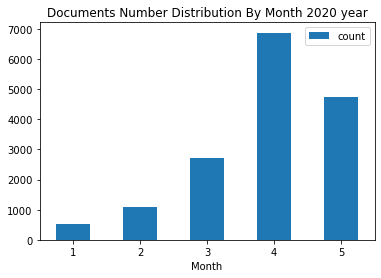

In [29]:
df2020_doc.plot.bar(x = "Month", y = "count", title="Documents Number Distribution By Month 2020 year", rot=0)
plt.show(block=True);

As we can see the most documents were published in April.

In [93]:
df_2020_results.to_csv(FORMATTED_FILES_DIR + RESULTS_FILE_NAME, index=False, encoding='utf-8')

### Read Drugs data from RxNav Rest API

Get drugs names from RxNav Rest API <br/>
uses term types (TTYs)
- IN - Ingredient. A compound or moiety that gives the drug its distinctive clinical properties. Ingredients generally use the United States Adopted Name (USAN). E.g. *Fluoxetine*
- BN - Brand Name. A proprietary name for a family of products containing a specific active ingredient. E.g. *Prozac*

In [34]:
RXNORM_IN_URL = 'https://rxnav.nlm.nih.gov/REST/allconcepts?tty=IN'
RXNORM_BN_URL = 'https://rxnav.nlm.nih.gov/REST/allconcepts?tty=BN'

In [35]:
response_in = requests.get(RXNORM_IN_URL)
tree_in = ET.fromstring(response_in.content)
response_bn = requests.get(RXNORM_BN_URL)
tree_bn = ET.fromstring(response_bn.content)

In [36]:
drugs_list = []
# Find names
for Variable in tree_in.findall('*//name'):
        drugs_list.append(Variable.text)
print("Length = ", len(drugs_list))

Length =  12587


In [37]:
for Variable in tree_bn.findall('*//name'):
        drugs_list.append(Variable.text)
print("Length = ", len(drugs_list))

Length =  18176


Create a set of Drugs names (unique)

In [38]:
drugs_unique = list(set(drugs_list))
drugs_unique.sort()

Save drugs to file

In [39]:
with open(FORMATTED_FILES_DIR + DRUGS_FILE_NAME, "w") as outfile:
    outfile.write("\n".join(drugs_unique))

## 3. Methodology<a name="methodology"></a>

Synonyms of COVID-19

In [40]:
covid_names = [
    "covid-19",
    "covid19",
    "2019-ncov",
    "2019ncov",
    "coronavirus",
    "sars-cov-2",
    "sarscov2"]

Read our previosuly created 'Result Cleaned' CSV file with Full Text articles from 2020 year

In [41]:
csv_results = []
with codecs.open(FORMATTED_FILES_DIR + RESULTS_FILE_NAME,'r', encoding='utf-8')as f:
     csv_results = list(csv.reader(f))

print("CSV Results file size = ", len(csv_results))        

CSV Results file size =  15945


In [42]:
print(csv_results[0])

['paper_id', 'publish_date', 'title', 'authors', 'abstract', 'text']


Create a dictionary of sentences for each document

In [43]:
all_sentences = {}
for i, record in enumerate(csv_results, start=1):
    sentences = []
    # get full text
    # add additional spaces arounf dots to improve sentence
    full_text =  re.sub(r'([a-z])\.([A-Z])', r'\1. \2', record[5])
    full_text =  re.sub(r'([a-z])\.([0-9])', r'\1. \2', full_text)
    full_text =  re.sub(r'([0-9]\])\.([A-Z])', r'\1. \2', full_text)
    full_text =  re.sub(r'([0-9]\))\.([A-Z])', r'\1. \2', full_text)   
    sent_text = nltk.sent_tokenize(full_text) 
    for sentence in sent_text:
        #remove New Line from the file
        str1 = sentence.replace("\n", "")
        sentences.append(str1)    
    all_sentences[record[0]] = sentences
print("All documents number: ", len(all_sentences))                            

All documents number:  15945


#### Normalize words (lowercase and remove stop words)

In [44]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We are using pre-defined Stop words list from NLTK library and manually add some stop words for the drugs names.

In [45]:
stop_words = stopwords.words('english')
drugs_stop_words = ['rna', 'lead', 'air', 'oxygen', 'perform', 'water', 'diamond', 'matrix', 'gold', 'today',
                   'sodium', 'blockade', 'align', 'copper', 'excel','calcium', 'nicotine', 'iron',
                   'latex', 'fiber', 'legacy', 'formalin', 'tomorrow', 'formaldehyde', 'methanol',
                   'pronto', 'android','longrange', 'overtime','acetone','revolution',
                   'glucose', 'ethanol', 'cocaine','heroin', 'supreme', 'zinc', 'pacebo', 'glycine',
                   'poliovirus', 'protease']

Remove noise: punctuation, stop words and lowercase all words. <br/>
I decided not to use Lemmatizer because we are going to use Drugs Names for search (not common English words)

In [46]:
def remove_noise(tokens, stop_words = ()):
    cleaned_tokens = []
    for token in tokens:
#        lemmatizer = WordNetLemmatizer()
#        token = lemmatizer.lemmatize(token)
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

#### Define sentences with 'COVID-19' and synonyms 

In [47]:
#Define sentences' indexes with Covid-19 mentioned
#Iterate Documents
covid19_sentences_indexes = {}
for key, doc in all_sentences.items():
    #Iterate Sentences in document
    for i, sentence in enumerate(doc):
         tokenized_text = nltk.word_tokenize(sentence)
         #lowercase all words from the sentence
         words_lower = [item.lower() for item in tokenized_text]
         if any(word in words_lower for word in covid_names):          
            if key not in covid19_sentences_indexes:
                 covid19_sentences_indexes[key] = [i]
            else:
                 covid19_sentences_indexes[key].append(i)
                
# Number of sentences with Covid-19 mentioned
print("Number of Documents with Covid-19 mentioned: ", len(covid19_sentences_indexes))    

Number of Documents with Covid-19 mentioned:  13121


Lowercase all drugs names and add 'Arbidol' because it absent in RxNorm  database.

In [48]:
#lowercase all drugs
drugs_unique_lower = [item.lower() for item in drugs_unique]
#remove stop words
drugs_unique_lower_wstop = list(filter(lambda w: w not in drugs_stop_words, drugs_unique_lower))
drugs_unique_lower_wstop.append('arbidol')

In [49]:
len(drugs_unique_lower_wstop)

18137

#### Define sentences with Drugs mentioned nearest the 'Covid-19' sentenses

In [50]:
windows_size = 2
drugs_sentences_indexes = {}
#Iterate thru Documents
for key, s_indexes in covid19_sentences_indexes.items():
    passed_indexes = []
    for i, index in enumerate(s_indexes):
    #check current sentence and windows_size ahead sentences for Drugs
        for j in range(windows_size):
            current_index = index + j
            if current_index >= len(all_sentences[key]):
                continue
            current_sentence = all_sentences[key][current_index]
            tokenized_text = nltk.word_tokenize(current_sentence)
            #lowercase all words from the sentence and clear noise
            #words_lower = [item.lower() for item in tokenized_text]
            tokens_cleaned = remove_noise(tokenized_text, stop_words)
            # check Drugs
            if (current_index not in passed_indexes) & (any(word in tokens_cleaned for word in drugs_unique_lower_wstop)):
                   if key not in drugs_sentences_indexes:
                        drugs_sentences_indexes[key] = [current_index]
                   else:
                        drugs_sentences_indexes[key].append(current_index)                        
                   passed_indexes.append(current_index)

# Number of sentences with drugs mentioned
print("Number of sentences with drugs mentioned: ", len(drugs_sentences_indexes))      


Number of sentences with drugs mentioned:  2912


In [51]:
# Create a file with Drugs and nearby Coronavirus sentences
drugs_sentences_result ={}
all_drug_sentences = []
for key, s_indexes in drugs_sentences_indexes.items():
     for i, index in enumerate(s_indexes):
            current_sentence = all_sentences[key][index]     
            all_drug_sentences.append(current_sentence)
            if key not in drugs_sentences_result:
                drugs_sentences_result[key] = [current_sentence]
            else:
                drugs_sentences_result[key].append(current_sentence)

Save the file with Drugs and neaby Coronavirus sentences

In [52]:
df_results_drugs = pd.json_normalize(drugs_sentences_result)
df_results_drugs_tr = df_results_drugs.transpose()
df_results_drugs_tr.head()

,0
PMC7063555,"[However, many forms of specific treatment are..."
PMC7113449,"[Hence, COVID-19 patients would benefit from t..."
PMC7113450,[While their effects are yet to be proven by c...
PMC7118684,"[Par ailleurs, comme les autres CoV, SARS-CoV-..."
PMC7139703,[Unsymmetrical aromatic disulfides obtained fr...


In [4]:
df_sentiment = pd.read_csv(LABELED_SENTIMENT_FILE_NAME)

In [53]:
import random
random.shuffle(all_drug_sentences)
df_results_drugs_tr.to_csv(FORMATTED_FILES_DIR + "Drugs Sentence.csv",  encoding='utf-8')
with codecs.open(FORMATTED_FILES_DIR + "Drugs Sentences All.csv",'w', encoding='utf-8')as f:
     f.write("\n".join(all_drug_sentences))
        
        def label_category(score):
    return 'positive' if score >=6  else 'negative' if score >= 4 else 'neutral' 

In [2]:
#create sentiment feature from ratings
if rating > 4 sentiment = neutral
if rating > 6 sentiment = positive
if rating < 5 sentiment = negative
merged_data['sentiment'] = merged_data["rating"]

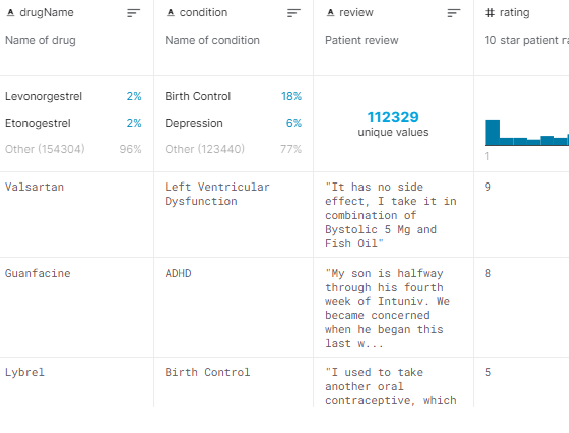

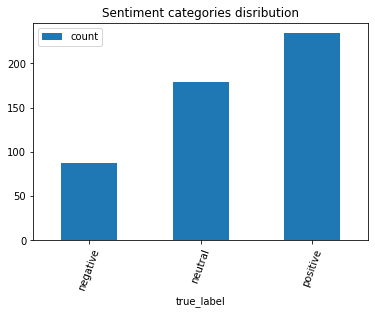

In [58]:
dfc.plot.bar(x = "true_label", y = "count", rot=70, title="Sentiment categories disribution");
plt.show(block=True);

### Vader Sentiment Analysis
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. <br/>


In [59]:
vader = SentimentIntensityAnalyzer()

In [60]:
def vader_score(text):
        return vader.polarity_scores(text)['compound']
    
def vader_category(score):
        return 'positive' if score > 0 else 'negative' if score < 0 else 'neutral' 

In [61]:
df_sentiment_vader = df_sentiment.copy()
df_sentiment_vader['score'] = df_sentiment_vader['sentence'].apply(vader_score)
df_sentiment_vader['prediction'] = df_sentiment_vader['score'].apply(vader_category)
df_sentiment_vader = df_sentiment_vader.drop('score', axis=1)
df_sentiment_vader = df_sentiment_vader.drop('label', axis=1)
df_sentiment_vader

,sentence,true_label,prediction
0,"However, it is not clear whether the anti-viru...",neutral,negative
1,"However, the use of ribavirin is associated wi...",negative,positive
2,"According to preliminary reports [50 , 51] fro...",positive,negative
3,"Notably, inhibition of mTOR with sirolimus red...",positive,negative
4,"Chlorpromazine, an antipsychotic (via dopamine...",neutral,negative
...,...,...,...
495,Tocilizumab is known to improve insulin resist...,positive,positive
496,Remdesivir is now being tested in several clin...,neutral,positive
497,This analysis provides a rational dose optimis...,neutral,positive
498,Both servers predictions were consistent and p...,neutral,neutral


In [62]:
y_true = df_sentiment_vader['true_label']
y_pred = df_sentiment_vader['prediction']

#### Calcuate model performace for Vader classification

In [63]:
results = confusion_matrix(y_true, y_pred) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_true, y_pred)) 
print('Report : ')
print(classification_report(y_true, y_pred))

Confusion Matrix :
[[ 52  12  23]
 [ 57  66  56]
 [ 62  50 122]]
Accuracy Score : 0.48
Report : 
              precision    recall  f1-score   support

    negative       0.30      0.60      0.40        87
     neutral       0.52      0.37      0.43       179
    positive       0.61      0.52      0.56       234

    accuracy                           0.48       500
   macro avg       0.48      0.50      0.46       500
weighted avg       0.52      0.48      0.49       500



#### Display Confusion Matrix for Vader classification

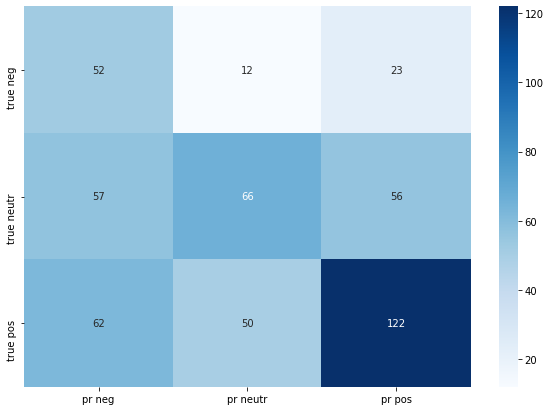

In [64]:
df_cm = pd.DataFrame(results, index = ['true neg', 'true neutr', 'true pos'], columns = ['pr neg', 'pr neutr', 'pr pos'])
plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, cmap='Blues', annot=True, fmt='d')

**As we can see the accuracy is low - equal just random choice**

### Summary table


| Algorithm | Accuracy | F1 Macro         
| - |------------- | -
| Vader | 0.48 | 0.46



### TextBlob Sentiment Analysis
TextBlob is a popular Python library for processing textual data. It is built on top of NLTK, another popular Natural Language Processing toolbox for Python. <br/>
TextBlob uses a sentiment lexicon (consisting of predefined words) to assign scores for each word, which are then averaged out using a weighted average to give an overall sentence sentiment score. <br/>
Three scores: “polarity”, “subjectivity” and “intensity” are calculated for each word. <br/>
We are interested only in “polarity”: <br/>
&nbsp;&nbsp;&nbsp;negative vs. positive (-1.0 => +1.0) <br/> 

In [65]:
def textblob_score(text):
        return TextBlob(text).sentiment.polarity
    
def textblob_category(score):
        return 'positive' if score > 0 else 'negative' if score < 0 else 'neutral' 

In [66]:
df_sentiment_textblob = df_sentiment.copy()
df_sentiment_textblob['score'] = df_sentiment_textblob['sentence'].apply(textblob_score)
df_sentiment_textblob['prediction'] = df_sentiment_textblob['score'].apply(textblob_category)
df_sentiment_textblob = df_sentiment_textblob.drop('score', axis=1)
df_sentiment_textblob = df_sentiment_textblob.drop('label', axis=1)
df_sentiment_textblob.head()

,sentence,true_label,prediction
0,"However, it is not clear whether the anti-viru...",neutral,negative
1,"However, the use of ribavirin is associated wi...",negative,positive
2,"According to preliminary reports [50 , 51] fro...",positive,positive
3,"Notably, inhibition of mTOR with sirolimus red...",positive,positive
4,"Chlorpromazine, an antipsychotic (via dopamine...",neutral,positive


#### Calcuate model performace for TextBlob classification

In [67]:
y_true = df_sentiment_textblob['true_label']
y_pred = df_sentiment_textblob['prediction']

In [68]:
results = confusion_matrix(y_true, y_pred) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_true, y_pred)) 
print('Report : ')
print(classification_report(y_true, y_pred))

Confusion Matrix :
[[ 25  27  35]
 [ 37  74  68]
 [ 23  84 127]]
Accuracy Score : 0.452
Report : 
              precision    recall  f1-score   support

    negative       0.29      0.29      0.29        87
     neutral       0.40      0.41      0.41       179
    positive       0.55      0.54      0.55       234

    accuracy                           0.45       500
   macro avg       0.42      0.41      0.41       500
weighted avg       0.45      0.45      0.45       500



#### Display Confusion Matrix for TextBlob classification

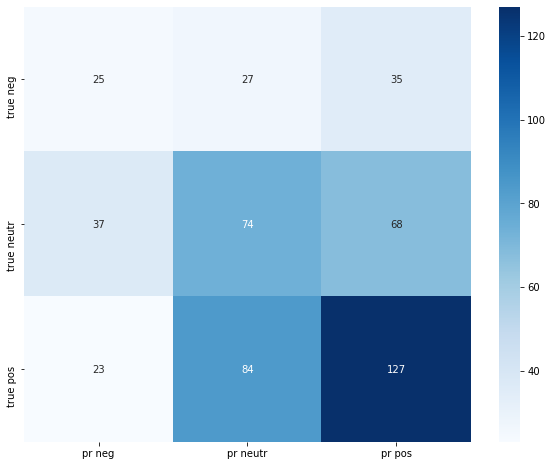

In [69]:
df_cm = pd.DataFrame(results, index = ['true neg', 'true neutr', 'true pos'], columns = ['pr neg', 'pr neutr', 'pr pos'])
plt.figure(figsize = (10, 8))
ax = sn.heatmap(df_cm, cmap='Blues', annot=True, fmt='d')

**The results for TextBlob are worse than we saw for the Vader classifier**

### Summary table


| Algorithm | Accuracy | F1 Macro         
| - |------------- | -
| Vader | 0.48 | 0.46
| TextBlob | 0.45 | 0.41


In [94]:
df_sentiment_keras['label'] = df_sentiment_keras['true_label'].map({'neutral': 2, 'positive': 4, 'negative': 1})
df_sentiment_keras.head()

,label,sentence,true_label
0,1,"However, it is not clear whether the anti-viru...",neutral
1,0,"However, the use of ribavirin is associated wi...",negative
2,2,"According to preliminary reports [50 , 51] fro...",positive
3,2,"Notably, inhibition of mTOR with sirolimus red...",positive
4,1,"Chlorpromazine, an antipsychotic (via dopamine...",neutral


Split data on test (30%) and training (70%) sets

In [95]:
X_train, X_test, y_train, y_test = train_test_split(df_sentiment_keras['sentence'], df_sentiment_keras['label'], test_size=0.3, random_state=42)

Textual data has to be converted into numeric form before it can be used by deep learning models. <br/>
One way to convert text to numbers is via word embeddings.
In word embeddings, every word is represented as an n-dimensional dense vector. <br/> 
The words that are similar will have similar vector. Word embeddings techniques such as GloVe and Word2Vec have proven to be extremely efficient for converting words into corresponding dense vectors. The vector size is small and none of the indexes in the vector is actually empty. <br/>

In [96]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['sentence'])

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Next, we need to load the built-in GloVe word embeddings. <br/>
Finally, we will create an embedding matrix where rows will be equal to the number of words in the vocabulary (plus 1). <br/> 
The number of columns will be 100 since each word in the GloVe word embeddings that we loaded is represented as a 100 dimensional vector.

In [97]:
embeddings_dictionary = dict()
glove_file = open(GLOVE_FILE_NAME, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

We will create a very simple model with one input layer (embedding layer), one LSTM layer with 128 neurons and one dense layer that will act as the output layer as well. <br/>
Since we have 3 possible outputs, the number of neurons will be 3 and the activation function will be softmax. <br/>
We will use the categorical_crossentropy as our loss function and adam as the optimization function.

In [102]:
variables_for_classification = 3
epochs = 5
batch_size = 28

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(variables_for_classification, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 300, 100)          261900    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 379,535
Trainable params: 117,635
Non-trainable params: 261,900
_________________________________________________________________
None


Convert labels to_categorical 

In [99]:
train_labels = to_categorical(y_train, num_classes=variables_for_classification)

Train our model

In [103]:
history = model.fit(X_train, train_labels, epochs=epochs, batch_size=batch_size,validation_split=0.2, verbose=1, )

Train on 280 samples, validate on 70 samples
Epoch 1/5
280/280 [==============================] - 3s 12ms/step - loss: 0.6674 - acc: 0.6667 - val_loss: 0.5973 - val_acc: 0.6667
Epoch 2/5
280/280 [==============================] - 3s 11ms/step - loss: 0.6183 - acc: 0.6667 - val_loss: 0.5935 - val_acc: 0.6667
Epoch 3/5
280/280 [==============================] - 3s 11ms/step - loss: 0.6078 - acc: 0.6667 - val_loss: 0.5689 - val_acc: 0.6667
Epoch 4/5
280/280 [==============================] - 3s 11ms/step - loss: 0.6088 - acc: 0.6667 - val_loss: 0.5787 - val_acc: 0.6667
Epoch 5/5
280/280 [==============================] - 3s 11ms/step - loss: 0.6073 - acc: 0.6667 - val_loss: 0.5735 - val_acc: 0.6667


Evaluate model performance

In [104]:
test_labels = to_categorical(y_test, num_classes=variables_for_classification)
score = model.evaluate(X_test, test_labels, verbose=1)
print("Accuracy:", score[1])

150/150 [==============================] - 0s 3ms/step
Accuracy: 0.6666666865348816


Display how model accuracy is changing during epochs

In [5]:

plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.show()


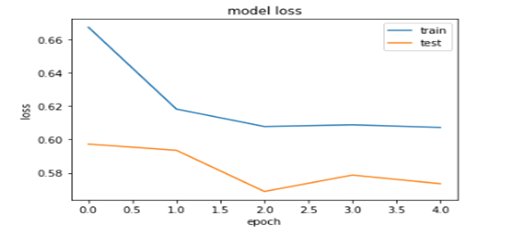

As we can see  we can use the limit of 2 epochs because after that accuracy stays the same

### Calculate normalized score for Drugs

Now we calculate the *Normalized sentiment score* : <br/> 

&nbsp;&nbsp;&nbsp;&nbsp; **(Avegare Score) * (Number of Document with drug mentioned / Total Number of Documents)**
<br/>

and show Top-20 Drugs names with the highest normalized scores

In [88]:
# Normalize Score
drugs_scores_normalized ={}
for key, value in drugs_scores.items():
    #total drug's score
    score = drugs_scores[key]
    
    #number of drug's scores
    count = drugs_scores_num[key]
    if count == 0:
        count = 1
    
    #number of document with the drug mentioned
    doc_count = drugs_scores_document[key]
    
    # Normalized score = summary score divided by number of scores and muplitly  
    # the number of document with drug mentioned divided by total number of documents
    norm_score = round((score / count) * (doc_count/document_count) * 100,2)
    drugs_scores_normalized[key] = [norm_score, round((score / count) * 100,2), doc_count]
    
# Check Top 20 Drugs with highest normalized score
drugs_scores_top = sorted(drugs_scores_normalized.items(), key=itemgetter(1), reverse = True) 

## 4.4 Covid-19 Drugs Final Scores   <a name="sentiment_analysis_final"></a>

And finally we will display a WordCloud chart with the Drugs Names

In [89]:
# Convert dictionary into Dataframe
# sentiment statistics per drug
df = pd.DataFrame([drugs_scores_normalized.keys(), drugs_scores_normalized.values()]).T
df.columns = ['drug', 'score']
df1 = pd.DataFrame(df['score'].to_list(), columns=[ 'normalized score', 'scores', 'documents'])
df = pd.merge(df, df1, left_index=True, right_index=True)
df
del df['score']
final_df = df.sort_values(by=['normalized score', 'scores', 'documents' ], ascending=False)
final_df.head(10)

,drug,normalized score,scores,documents
0,chloroquine,13.67,71.75,555
1,remdesivir,12.35,66.87,538
17,hydroxychloroquine,11.59,55.71,606
50,tocilizumab,6.95,70.79,286
44,lopinavir,5.62,71.47,229
46,ritonavir,4.86,71.43,198
19,azithromycin,3.69,38.64,278
31,ribavirin,3.33,56.04,173
63,arbidol,2.82,71.43,115
23,oseltamivir,2.35,48.48,141


In [90]:
data = dict(zip(final_df['drug'].tolist(), final_df['normalized score'].tolist()))

In [9]:
wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate_from_frequencies(data)
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
fig.subplots_adjust(top=2.3)

plt.imshow(wordcloud,cmap=plt.cm.gray, interpolation='bilinear')
plt.show()

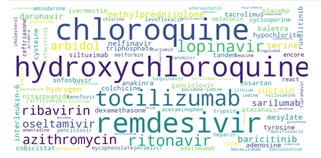

The Top-3 Drugs with the highest positive sentiments normalized scores were found with accuracy of 65%:
Chloroquine with score 13.67 extracted from 555 documents (total, with any sentiments)
Remdesivir with score 12.35 extracted from 538 documents (total, with any sentiments)
Hydroxychloroquine with score 11.59 extracted from 606 documents (total, with any sentiments)

Based on these in vitro findings, researchers rushed to study the effects of hydroxychloroquine and chloroquine in hospitalized patients with COVID-19. Early results were shared with the media, which led hospitals worldwide to start using these medications.

In hospitalized patients with Covid-19 pneumonia who were not receiving mechanical ventilation, tocilizumab reduced the likelihood of progression to the composite outcome of mechanical ventilation or death, but it did not improve survival.
